In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap
from sklearn.inspection import permutation_importance
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV, train_test_split
import optuna
from tqdm import tqdm
from statsmodels.tsa.seasonal import STL


In [ ]:
# Download stock data for Indomaret (IMFI.JK)
stock_data = yf.download("AALI.JK", start="2015-01-01", end="2024-01-01")

# Moving Averages
stock_data['SMA_5'] = stock_data['Close'].rolling(window=5).mean()
stock_data['SMA_10'] = stock_data['Close'].rolling(window=10).mean()
stock_data['SMA_15'] = stock_data['Close'].rolling(window=15).mean()
stock_data['SMA_30'] = stock_data['Close'].rolling(window=30).mean()

# Exponential Moving Average (EMA)
stock_data['EMA_9'] = stock_data['Close'].ewm(span=9, adjust=False).mean()

# MACD (Moving Average Convergence Divergence)
stock_data['EMA_12'] = stock_data['Close'].ewm(span=12, adjust=False).mean()
stock_data['EMA_26'] = stock_data['Close'].ewm(span=26, adjust=False).mean()
stock_data['MACD'] = stock_data['EMA_12'] - stock_data['EMA_26']
stock_data['Signal_Line'] = stock_data['MACD'].ewm(span=9, adjust=False).mean()

# Relative Strength Index (RSI)
delta = stock_data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
stock_data['RSI'] = 100 - (100 / (1 + rs))

# Williams %R (WPR)
highest_high = stock_data['High'].rolling(window=14).max()
lowest_low = stock_data['Low'].rolling(window=14).min()
stock_data['WPR'] = ((highest_high - stock_data['Close']) / (highest_high - lowest_low)) * -100

# Bollinger Bands
stock_data['BB_Middle'] = stock_data['Close'].rolling(window=20).mean()
stock_data['BB_Upper'] = stock_data['BB_Middle'] + 2 * stock_data['Close'].rolling(window=20).std()
stock_data['BB_Lower'] = stock_data['BB_Middle'] - 2 * stock_data['Close'].rolling(window=20).std()

# Average True Range (ATR)
stock_data['ATR'] = stock_data['High'] - stock_data['Low']

# Stochastic Oscillator (K)
stock_data['Stochastic_K'] = 100 * (stock_data['Close'] - stock_data['Low'].rolling(window=14).min()) / (stock_data['High'].rolling(window=14).max() - stock_data['Low'].rolling(window=14).min())

# On-Balance Volume (OBV)
stock_data['OBV'] = np.where(stock_data['Close'] > stock_data['Close'].shift(1), stock_data['Volume'], 
                             np.where(stock_data['Close'] < stock_data['Close'].shift(1), -stock_data['Volume'], 0)).cumsum()

# Chaikin Money Flow (CMF)
stock_data['CMF'] = (stock_data['Close'] - stock_data['Low']) - (stock_data['High'] - stock_data['Close']) / (stock_data['High'] - stock_data['Low']) * stock_data['Volume']

# Rate of Change (ROC)
stock_data['ROC'] = stock_data['Close'].pct_change(periods=12) * 100

# Money Flow Index (MFI)
stock_data['MFI'] = ((stock_data['Close'] - stock_data['Low']) + (stock_data['High'] - stock_data['Close'])) / stock_data['Volume']

# Drop NaN values after calculating technical indicators
stock_data.dropna(inplace=True)

# Download VIX data for Volatility Index
vix_data = yf.download('^VIX', start="2015-01-01", end="2024-01-01")
vix_data = vix_data[['Close']]  # Only keep 'Close' price of VIX
vix_data.rename(columns={'Close': 'VIX'}, inplace=True)

# Merge VIX data with stock data
stock_data = stock_data.join(vix_data, how='left')

# Add Time-based Features (Day, Month, Year)
stock_data['DayOfWeek'] = stock_data.index.dayofweek
stock_data['Month'] = stock_data.index.month
stock_data['Year'] = stock_data.index.year

# Add Lagged Features (Previous n days of Close price)
n_lags = 5  # Adjust based on how many previous days you want to include
for i in range(1, n_lags + 1):
    stock_data[f'Lag_{i}'] = stock_data['Close'].shift(i)

# Drop NaN values generated by lagged features
stock_data.dropna(inplace=True)

# Prepare Data for LSTM Model
feature_columns = [
    'EMA_9', 'SMA_5', 'SMA_10', 'SMA_15', 'SMA_30', 'MACD', 'Signal_Line', 'RSI', 'WPR', 
    'BB_Middle', 'BB_Upper', 'BB_Lower', 'ATR', 'Stochastic_K', 'OBV', 'CMF', 'ROC', 'MFI', 
    'DayOfWeek', 'Month', 'Year', 'VIX'
]
# Include Lagged features
feature_columns.extend([f'Lag_{i}' for i in range(1, n_lags + 1)])

X = stock_data[feature_columns]
y = stock_data['Close']

# Normalize the features and target using MinMaxScaler
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_features.fit_transform(X)
y_scaled = scaler_target.fit_transform(y.values.reshape(-1, 1))

# Reshape data for LSTM
X_scaled = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])  # [samples, timesteps, features]

# Ensure proper data splits: Train (60%), Validation (20%), Test (20%)
train_size = int(len(X_scaled) * 0.6)
val_size = int(len(X_scaled) * 0.2)
test_size = len(X_scaled) - train_size - val_size

X_train, X_val, X_test = X_scaled[:train_size], X_scaled[train_size:train_size + val_size], X_scaled[train_size + val_size:]
y_train, y_val, y_test = y_scaled[:train_size], y_scaled[train_size:train_size + val_size], y_scaled[train_size + val_size:]

# Function for MAPE calculation
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to create LSTM model for Optuna optimization
def create_lstm_optuna(trial):
    units = trial.suggest_int("units", 50, 200, step=50)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    layers = trial.suggest_int("layers", 1, 3)
    
    model = Sequential()
    model.add(LSTM(units=units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]),
                   return_sequences=True if layers > 1 else False))
    model.add(Dropout(dropout_rate))
    for _ in range(1, layers):
        model.add(LSTM(units=units, activation='relu', return_sequences=True if _ < layers - 1 else False))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Optuna objective function for hyperparameter tuning
def objective(trial):
    model = create_lstm_optuna(trial)
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0, validation_data=(X_val, y_val))
    predictions = model.predict(X_val)
    predictions_rescaled = scaler_target.inverse_transform(predictions)
    y_val_rescaled = scaler_target.inverse_transform(y_val)
    rmse = np.sqrt(mean_squared_error(y_val_rescaled, predictions_rescaled))
    return rmse

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
C:\Users\sandi\AppData\Local\Temp\ipykernel_21336\1247841559.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vix_data.rename(columns={'Close': 'VIX'}, inplace=True)
[I 2024-12-05 21:05:31,931] A new study created in memory with name: no-name-d221c72f-bfcd-4e7b-be6e-62b3f8a3559d
c:\Users\sandi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step  


[I 2024-12-05 21:05:44,758] Trial 0 finished with value: 412.8777954800482 and parameters: {'units': 100, 'dropout_rate': 0.30000000000000004, 'layers': 2}. Best is trial 0 with value: 412.8777954800482.
c:\Users\sandi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step  


[I 2024-12-05 21:05:58,272] Trial 1 finished with value: 685.8690198028014 and parameters: {'units': 100, 'dropout_rate': 0.30000000000000004, 'layers': 2}. Best is trial 0 with value: 412.8777954800482.
c:\Users\sandi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  


[I 2024-12-05 21:06:07,625] Trial 2 finished with value: 795.7800602683062 and parameters: {'units': 150, 'dropout_rate': 0.5, 'layers': 1}. Best is trial 0 with value: 412.8777954800482.
c:\Users\sandi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best parameters: {'units': 100, 'dropout_rate': 0.2, 'layers': 1}
Epoch 1/50


c:\Users\sandi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0729 - val_loss: 0.0073
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 8.7670e-04
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 5.4919e-04
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - val_loss: 4.7416e-04
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - val_loss: 1.3199e-04
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 1.5774e-04
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 1.2404e-04
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016 - val_loss: 7.7429e-05
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016 - val_loss: 2.8957e-04
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019 - val_loss: 7.7213e-05
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013 - val_loss: 2.3926e-04
Epoch 12/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5m

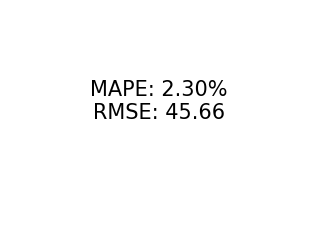

In [ ]:
# Best parameters from Optuna
best_params = study.best_params
print("Best parameters:", best_params)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train final model with best parameters and early stopping
best_model = create_lstm_optuna(study.best_trial)
best_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1,
               validation_data=(X_val, y_val), callbacks=[early_stopping])

# Predictions and performance metrics on test data
predictions = best_model.predict(X_test)
predictions_rescaled = scaler_target.inverse_transform(predictions)
y_test_rescaled = scaler_target.inverse_transform(y_test)

# Calculate performance metrics
mape = mean_absolute_percentage_error(y_test_rescaled, predictions_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))


# Final MAPE and RMSE
plt.subplot(2, 2, 4)
plt.text(0.5, 0.5, f'MAPE: {mape:.2f}%\nRMSE: {rmse:.2f}', fontsize=15, ha='center')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Predictions and performance metrics on training, validation, and test data
def evaluate_performance(model, X, y, scaler_target, dataset_name="Dataset"):
    predictions = model.predict(X)
    predictions_rescaled = scaler_target.inverse_transform(predictions)
    y_rescaled = scaler_target.inverse_transform(y)
    
    rmse = np.sqrt(mean_squared_error(y_rescaled, predictions_rescaled))
    mae = mean_absolute_error(y_rescaled, predictions_rescaled)
    mape = mean_absolute_percentage_error(y_rescaled, predictions_rescaled)
    r2 = r2_score(y_rescaled, predictions_rescaled)

    print(f"{dataset_name} RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%, R2: {r2:.2f}")
    return rmse, mae, mape, r2

# Evaluate on Training, Validation, and Test sets
print("\nPerformance on Training Set:")
train_rmse, train_mae, train_mape, train_r2 = evaluate_performance(best_model, X_train, y_train, scaler_target, "Training")

print("\nPerformance on Validation Set:")
val_rmse, val_mae, val_mape, val_r2 = evaluate_performance(best_model, X_val, y_val, scaler_target, "Validation")

print("\nPerformance on Test Set:")
test_rmse, test_mae, test_mape, test_r2 = evaluate_performance(best_model, X_test, y_test, scaler_target, "Test")



Performance on Training Set:
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training RMSE: 82.28, MAE: 49.05, MAPE: 2.91%, R2: 0.99

Performance on Validation Set:
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Validation RMSE: 30.12, MAE: 23.27, MAPE: 2.33%, R2: 0.98

Performance on Test Set:
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Test RMSE: 45.66, MAE: 31.60, MAPE: 2.30%, R2: 0.99


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


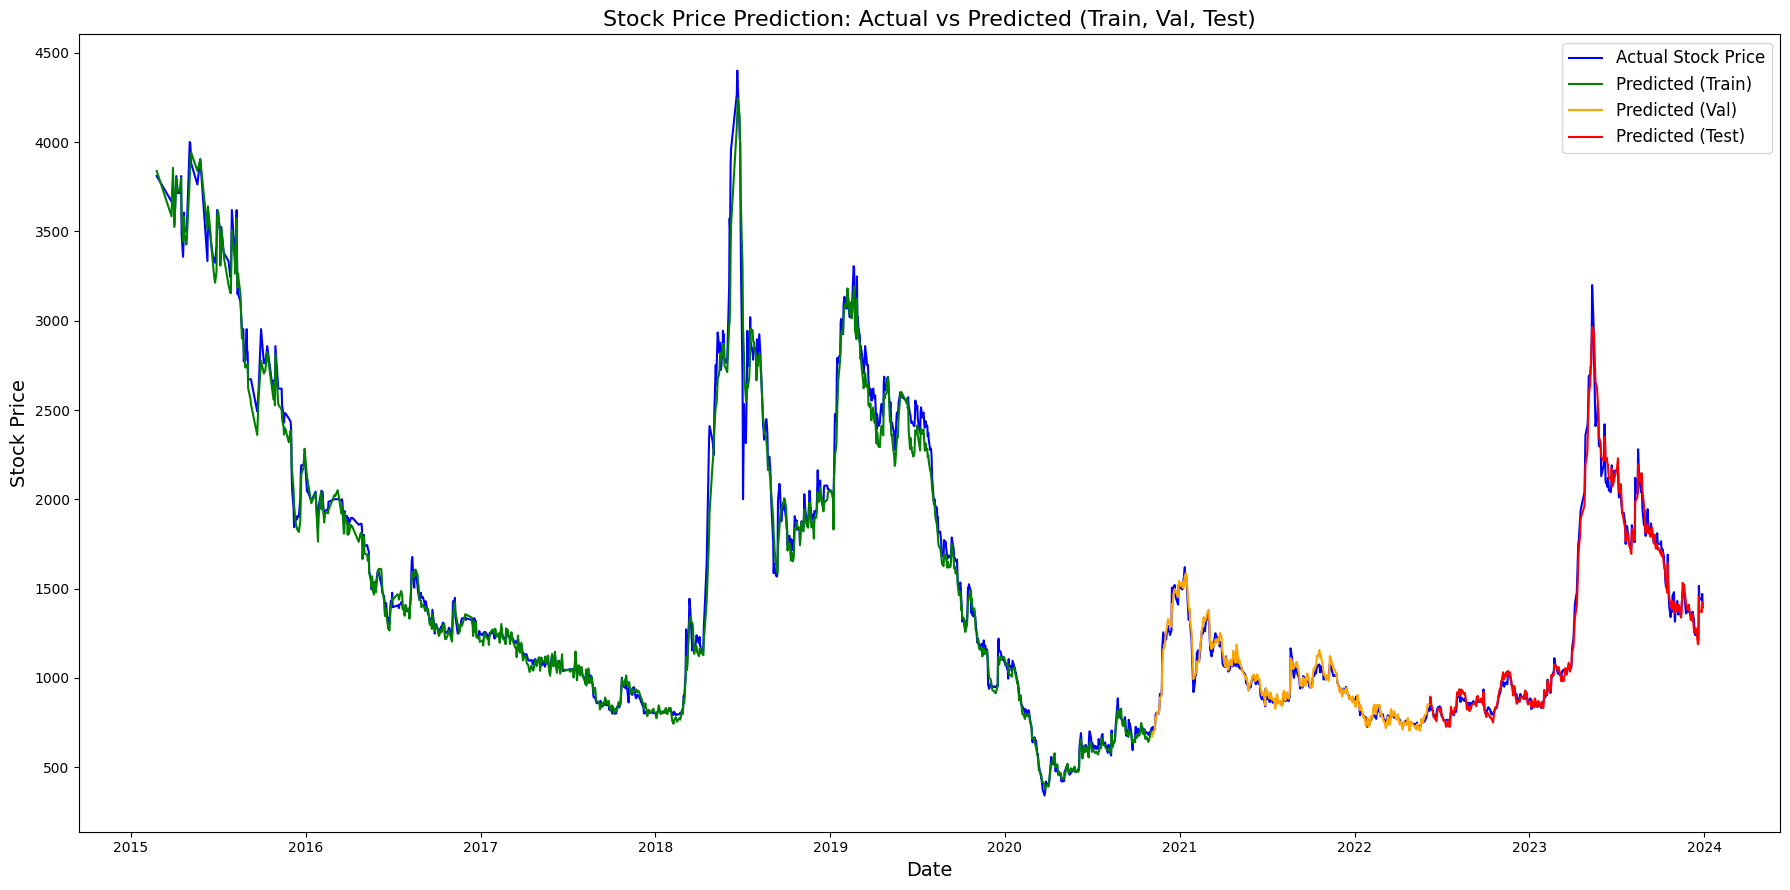

In [ ]:
import matplotlib.pyplot as plt

# Ensure that the predictions on training, validation, and test sets are obtained
train_predictions = best_model.predict(X_train)
val_predictions = best_model.predict(X_val)
test_predictions = best_model.predict(X_test)

# Rescale the predictions back to the original scale
train_predictions_rescaled = scaler_target.inverse_transform(train_predictions)
val_predictions_rescaled = scaler_target.inverse_transform(val_predictions)
test_predictions_rescaled = scaler_target.inverse_transform(test_predictions)

# Rescale the actual values to the original scale
y_train_rescaled = scaler_target.inverse_transform(y_train)
y_val_rescaled = scaler_target.inverse_transform(y_val)
y_test_rescaled = scaler_target.inverse_transform(y_test)

# Plotting the four components: Actual, Training, Validation, and Test
plt.figure(figsize=(18, 9))  # Increase figure size here

# Plot actual stock prices (entire dataset)
plt.plot(stock_data.index[:len(y_train_rescaled)+len(y_val_rescaled)+len(y_test_rescaled)], 
         np.concatenate([y_train_rescaled, y_val_rescaled, y_test_rescaled]), 
         label='Actual Stock Price', color='blue')

# Plot predicted stock prices for training set
plt.plot(stock_data.index[:len(train_predictions_rescaled)], train_predictions_rescaled, label='Predicted (Train)', color='green')

# Plot predicted stock prices for validation set
plt.plot(stock_data.index[len(train_predictions_rescaled):len(train_predictions_rescaled)+len(val_predictions_rescaled)], 
         val_predictions_rescaled, label='Predicted (Val)', color='orange')

# Plot predicted stock prices for test set
plt.plot(stock_data.index[len(train_predictions_rescaled)+len(val_predictions_rescaled):], 
         test_predictions_rescaled, label='Predicted (Test)', color='red')

# Add title and labels
plt.title('Stock Price Prediction: Actual vs Predicted (Train, Val, Test)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Stock Price', fontsize=14)

# Add legend
plt.legend(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


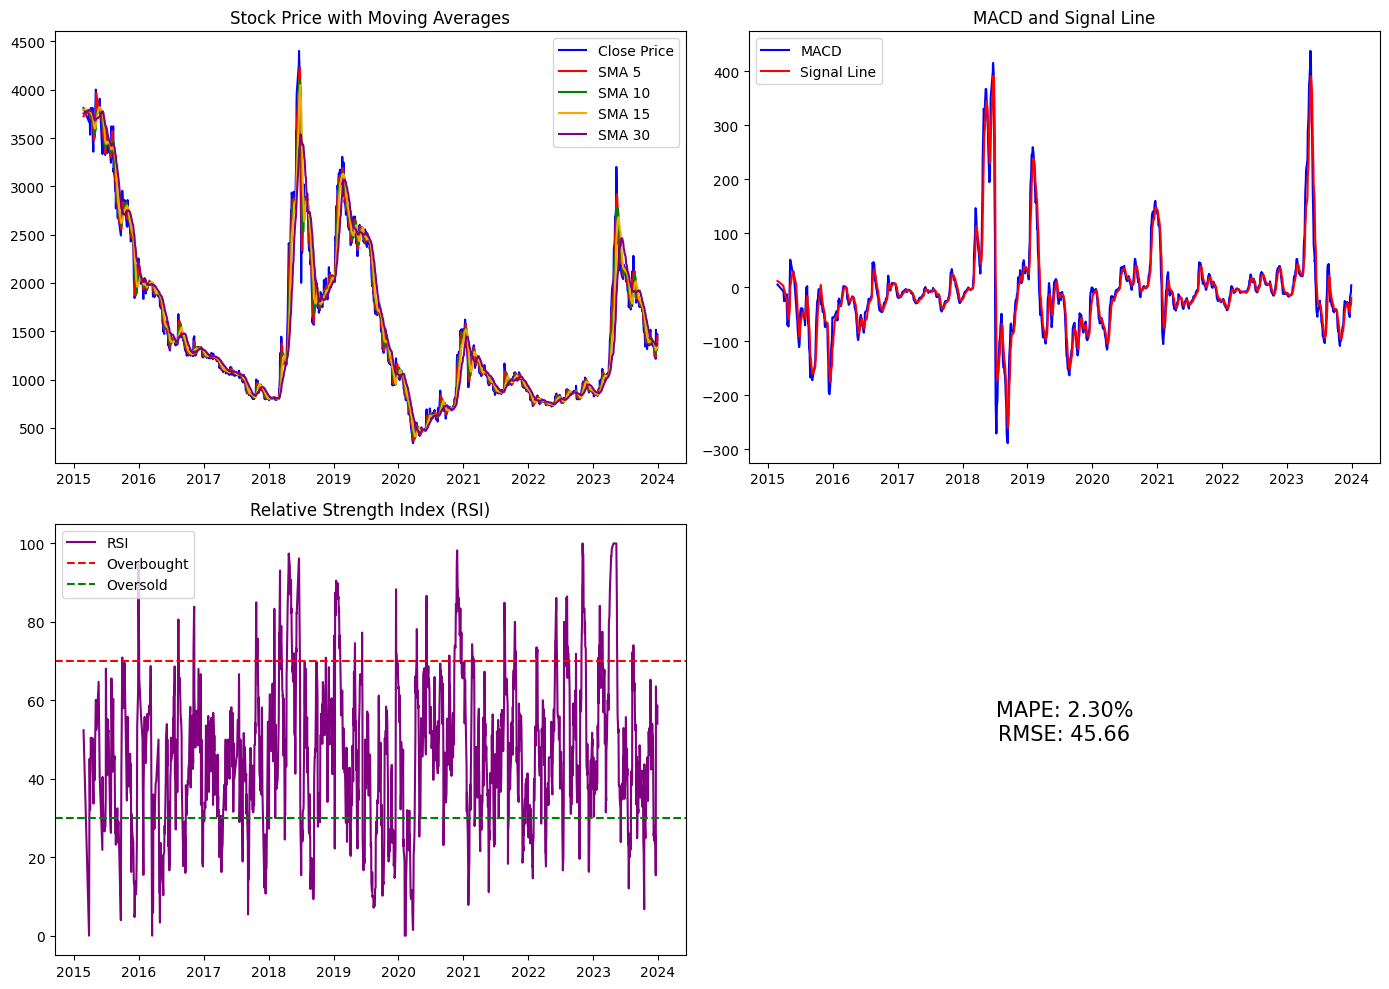

In [ ]:
# Plotting stock data and indicators
plt.figure(figsize=(14, 10))

# Plot the closing price and moving averages
plt.subplot(2, 2, 1)
plt.plot(stock_data['Close'], label='Close Price', color='blue')
plt.plot(stock_data['SMA_5'], label='SMA 5', color='red')
plt.plot(stock_data['SMA_10'], label='SMA 10', color='green')
plt.plot(stock_data['SMA_15'], label='SMA 15', color='orange')
plt.plot(stock_data['SMA_30'], label='SMA 30', color='purple')
plt.title('Stock Price with Moving Averages')
plt.legend(loc='best')

# Plot MACD and Signal Line
plt.subplot(2, 2, 2)
plt.plot(stock_data['MACD'], label='MACD', color='blue')
plt.plot(stock_data['Signal_Line'], label='Signal Line', color='red')
plt.title('MACD and Signal Line')
plt.legend(loc='best')

# Plot RSI
plt.subplot(2, 2, 3)
plt.plot(stock_data['RSI'], label='RSI', color='purple')
plt.axhline(70, color='red', linestyle='--', label='Overbought')
plt.axhline(30, color='green', linestyle='--', label='Oversold')
plt.title('Relative Strength Index (RSI)')
plt.legend(loc='best')

# Final MAPE and RMSE
plt.subplot(2, 2, 4)
plt.text(0.5, 0.5, f'MAPE: {mape:.2f}%\nRMSE: {rmse:.2f}', fontsize=15, ha='center')
plt.axis('off')

plt.tight_layout()
plt.show()

100%|██████████| 27/27 [00:02<00:00,  9.62it/s]


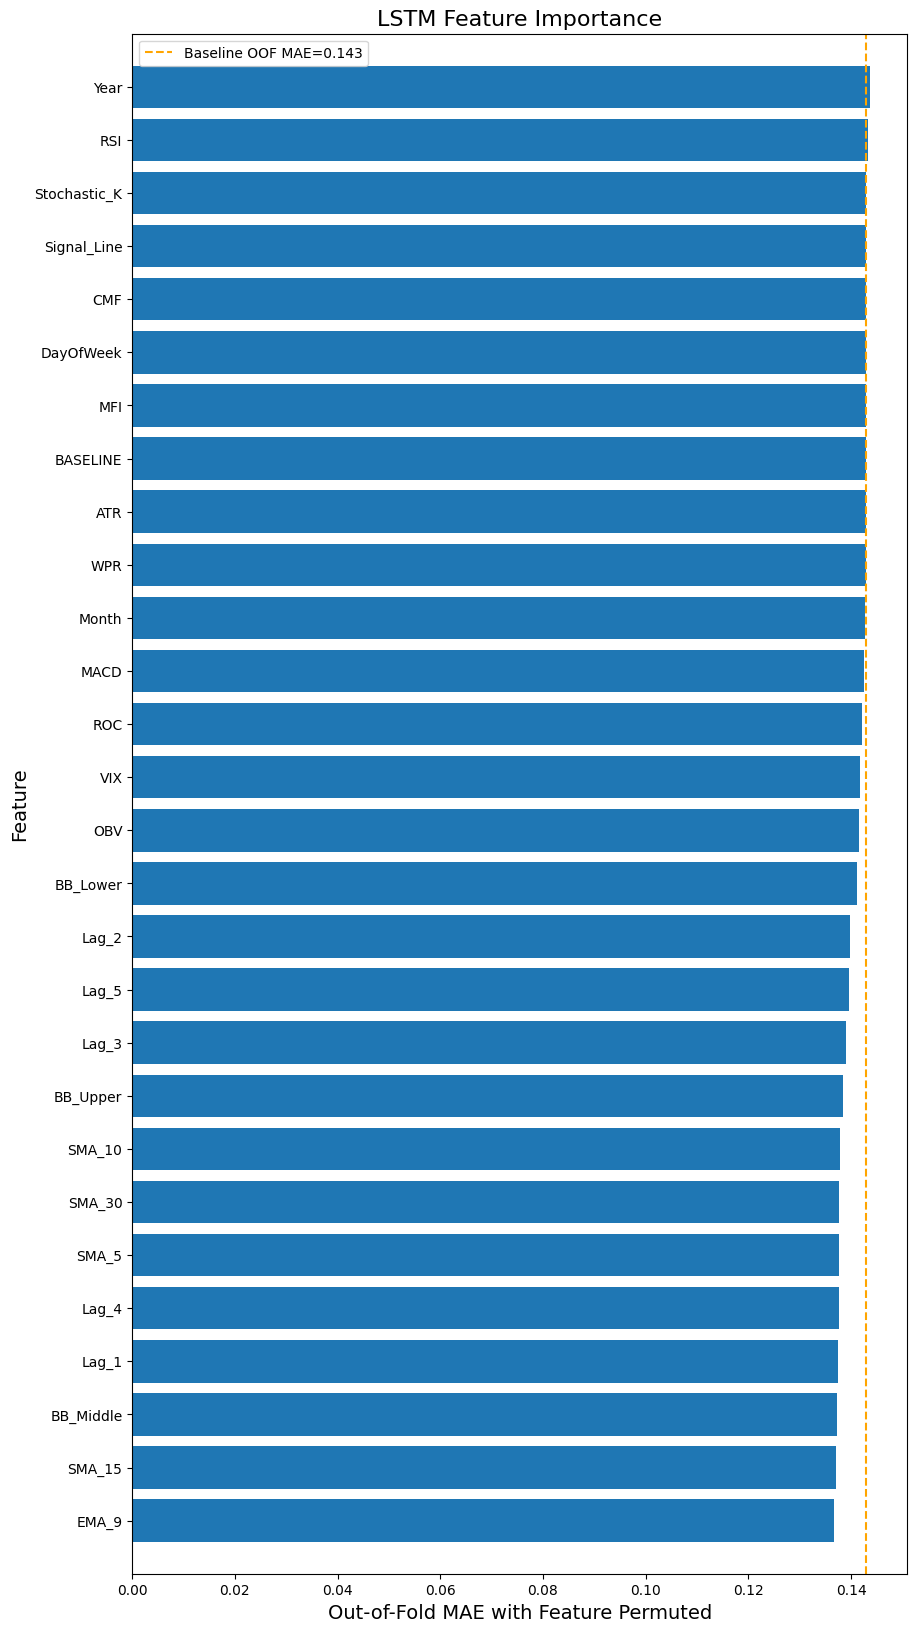

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


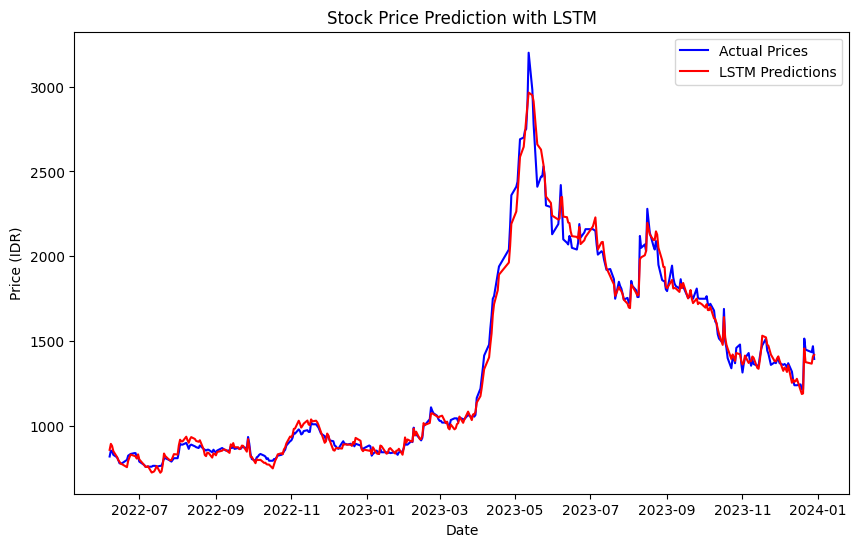

In [ ]:
# ------------------------
# SHAP (Shapley Additive Explanations)
# ------------------------



# Compute Baseline MAE (without any shuffling)
oof_preds = best_model.predict(X_test, verbose=0).squeeze()  # Get out-of-fold predictions
baseline_mae = np.mean(np.abs(oof_preds - y_test))  # Calculate MAE
results = [{'feature': 'BASELINE', 'mae': baseline_mae}]

# Iterate through each feature and shuffle it
for k in tqdm(range(X_test.shape[2])):  # Loop through all features (columns)
    # Save the original column to restore it after shuffling
    save_col = X_test[:, :, k].copy()
    
    # Shuffle the feature column
    np.random.shuffle(X_test[:, :, k])
    
    # Get out-of-fold predictions after shuffling the feature
    oof_preds = best_model.predict(X_test, verbose=0).squeeze()
    
    # Calculate MAE with the shuffled feature
    mae = np.mean(np.abs(oof_preds - y_test))
    
    # Store the result for the shuffled feature
    results.append({'feature': feature_columns[k], 'mae': mae})
    
    # Restore the original feature column
    X_test[:, :, k] = save_col

# Convert results into a DataFrame for easier analysis
df = pd.DataFrame(results)
df = df.sort_values('mae')

# Plot the feature importance
plt.figure(figsize=(10, 20))
plt.barh(np.arange(len(df)), df['mae'])
plt.yticks(np.arange(len(df)), df['feature'].values)
plt.title('LSTM Feature Importance', size=16)
plt.ylim((-1, len(df)))
plt.axvline(x=baseline_mae, color='orange', linestyle='--', label=f'Baseline OOF MAE={baseline_mae:.3f}')
plt.xlabel('Out-of-Fold MAE with Feature Permuted', size=14)
plt.ylabel('Feature', size=14)
plt.legend()
plt.show()

# Save feature importance to CSV file
df.to_csv('lstm_feature_importance.csv', index=False)



# ------------------------
# Plotting the Predictions vs Actuals
# ------------------------

# Ensure predictions are in the correct shape
predictions = best_model.predict(X_test)
predictions_rescaled = scaler_target.inverse_transform(predictions)

# Plotting the actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.plot(stock_data.index[-len(y_test):], scaler_target.inverse_transform(y_test.reshape(-1, 1)), label='Actual Prices', color='blue')
plt.plot(stock_data.index[-len(predictions_rescaled):], predictions_rescaled, label='LSTM Predictions', color='red')
plt.title('Stock Price Prediction with LSTM')
plt.xlabel('Date')
plt.ylabel('Price (IDR)')
plt.legend()
plt.show()


Features to be removed from the analysis:
['Lag_1', 'Lag_2']


  0%|          | 0/27 [00:00<?, ?it/s]

Evaluating feature importance: Shuffling 'EMA_9'


  4%|▎         | 1/27 [00:00<00:03,  7.29it/s]

Evaluating feature importance: Shuffling 'SMA_5'


  7%|▋         | 2/27 [00:00<00:03,  7.42it/s]

Evaluating feature importance: Shuffling 'SMA_10'
Evaluating feature importance: Shuffling 'SMA_15'


 15%|█▍        | 4/27 [00:00<00:02,  8.68it/s]

Evaluating feature importance: Shuffling 'SMA_30'


 19%|█▊        | 5/27 [00:00<00:02,  8.63it/s]

Evaluating feature importance: Shuffling 'MACD'


 22%|██▏       | 6/27 [00:00<00:02,  7.61it/s]

Evaluating feature importance: Shuffling 'Signal_Line'


 26%|██▌       | 7/27 [00:00<00:02,  7.89it/s]

Evaluating feature importance: Shuffling 'RSI'


 30%|██▉       | 8/27 [00:00<00:02,  8.29it/s]

Evaluating feature importance: Shuffling 'WPR'
Evaluating feature importance: Shuffling 'BB_Middle'


 41%|████      | 11/27 [00:01<00:01,  8.58it/s]

Evaluating feature importance: Shuffling 'BB_Upper'
Evaluating feature importance: Shuffling 'BB_Lower'


 48%|████▊     | 13/27 [00:01<00:01,  9.01it/s]

Evaluating feature importance: Shuffling 'ATR'
Evaluating feature importance: Shuffling 'Stochastic_K'


 56%|█████▌    | 15/27 [00:01<00:01,  9.27it/s]

Evaluating feature importance: Shuffling 'OBV'
Evaluating feature importance: Shuffling 'CMF'
Evaluating feature importance: Shuffling 'ROC'


 67%|██████▋   | 18/27 [00:02<00:00,  9.32it/s]

Evaluating feature importance: Shuffling 'MFI'
Evaluating feature importance: Shuffling 'DayOfWeek'


 74%|███████▍  | 20/27 [00:02<00:00,  9.20it/s]

Evaluating feature importance: Shuffling 'Month'
Evaluating feature importance: Shuffling 'Year'


 81%|████████▏ | 22/27 [00:02<00:00,  8.42it/s]

Evaluating feature importance: Shuffling 'VIX'
Skipping feature 'Lag_1' (as it is in the removal list).
Skipping feature 'Lag_2' (as it is in the removal list).
Evaluating feature importance: Shuffling 'Lag_3'
Evaluating feature importance: Shuffling 'Lag_4'


100%|██████████| 27/27 [00:02<00:00,  9.51it/s]


Evaluating feature importance: Shuffling 'Lag_5'


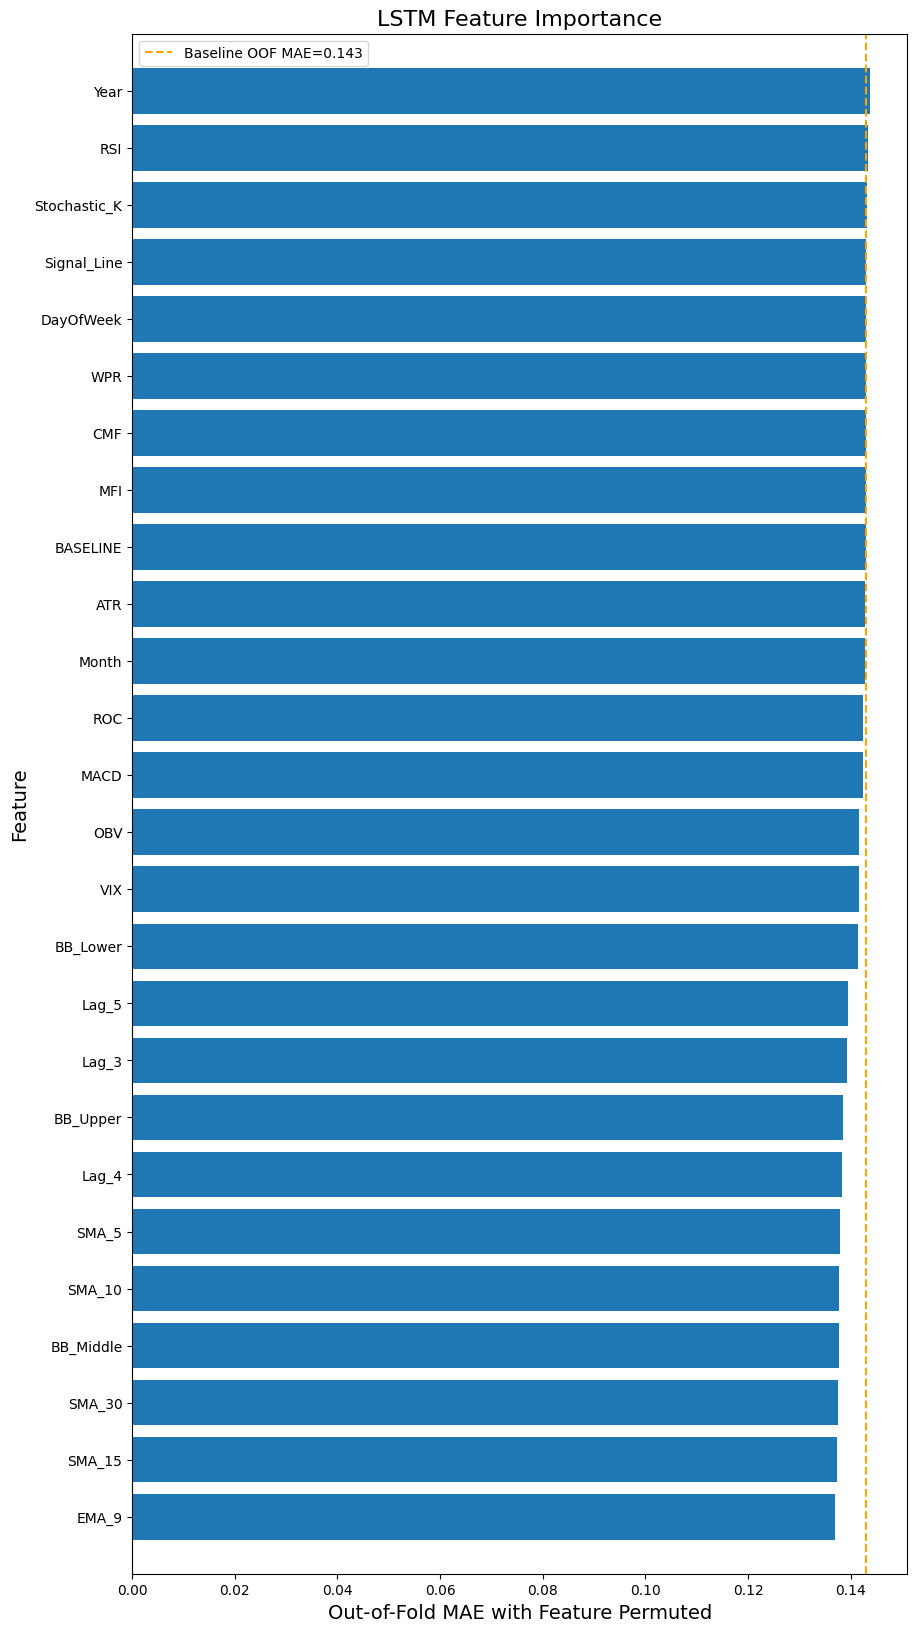

In [ ]:
# List of features that need to be removed (e.g., features with NaN or unwanted features)
features_to_remove = [feature for feature in feature_columns if feature in ['Lag_1', 'Lag_2']]  # Example: Remove Lag_1 and Lag_2

# Print out the features that need to be removed
print("Features to be removed from the analysis:")
print(features_to_remove)

# Compute Baseline MAE (without any shuffling)
oof_preds = best_model.predict(X_test, verbose=0).squeeze()  # Get out-of-fold predictions
baseline_mae = np.mean(np.abs(oof_preds - y_test))  # Calculate MAE
results = [{'feature': 'BASELINE', 'mae': baseline_mae}]

# Iterate through each feature and shuffle it
for k in tqdm(range(X_test.shape[2])):  # Loop through all features (columns)
    # Skip features in the 'features_to_remove' list
    if feature_columns[k] in features_to_remove:
        print(f"Skipping feature '{feature_columns[k]}' (as it is in the removal list).")
        continue  # Skip this feature
    
    # Print the feature being shuffled
    print(f"Evaluating feature importance: Shuffling '{feature_columns[k]}'")
    
    # Save the original column to restore it after shuffling
    save_col = X_test[:, :, k].copy()
    
    # Shuffle the feature column
    np.random.shuffle(X_test[:, :, k])
    
    # Get out-of-fold predictions after shuffling the feature
    oof_preds = best_model.predict(X_test, verbose=0).squeeze()
    
    # Calculate MAE with the shuffled feature
    mae = np.mean(np.abs(oof_preds - y_test))
    
    # Store the result for the shuffled feature
    results.append({'feature': feature_columns[k], 'mae': mae})
    
    # Restore the original feature column
    X_test[:, :, k] = save_col

# Convert results into a DataFrame for easier analysis
df = pd.DataFrame(results)
df = df.sort_values('mae')

# Plot the feature importance
plt.figure(figsize=(10, 20))
plt.barh(np.arange(len(df)), df['mae'])
plt.yticks(np.arange(len(df)), df['feature'].values)
plt.title('LSTM Feature Importance', size=16)
plt.ylim((-1, len(df)))
plt.axvline(x=baseline_mae, color='orange', linestyle='--', label=f'Baseline OOF MAE={baseline_mae:.3f}')
plt.xlabel('Out-of-Fold MAE with Feature Permuted', size=14)
plt.ylabel('Feature', size=14)
plt.legend()
plt.show()

# Save feature importance to CSV file
df.to_csv('lstm_feature_importance.csv', index=False)


In [ ]:
print("Features to be removed from the analysis:")
print(features_to_remove)


Features to be removed from the analysis:
['Lag_1', 'Lag_2']


In [ ]:
# Function to evaluate model performance
def evaluate_model(y_true, y_pred, scaler):
    y_true_rescaled = scaler.inverse_transform(y_true)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_true_rescaled, y_pred_rescaled)),
        'MAE': mean_absolute_error(y_true_rescaled, y_pred_rescaled),
        'MAPE': mean_absolute_percentage_error(y_true_rescaled, y_pred_rescaled),
        'R2': r2_score(y_true_rescaled, y_pred_rescaled)
    }
    return metrics

# Function to plot predictions
def plot_predictions(y_true, y_pred, dates, scaler, title='LSTM Stock Prediction'):
    y_true_rescaled = scaler.inverse_transform(y_true)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    plt.figure(figsize=(10, 6))
    plt.plot(dates, y_true_rescaled, label='Actual Prices', color='blue')
    plt.plot(dates, y_pred_rescaled, label='LSTM Predictions', color='red')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price (IDR)')
    plt.legend()
    plt.show()


Metrics: RMSE=45.66, MAE=31.60, MAPE=2.30%, R2=0.99


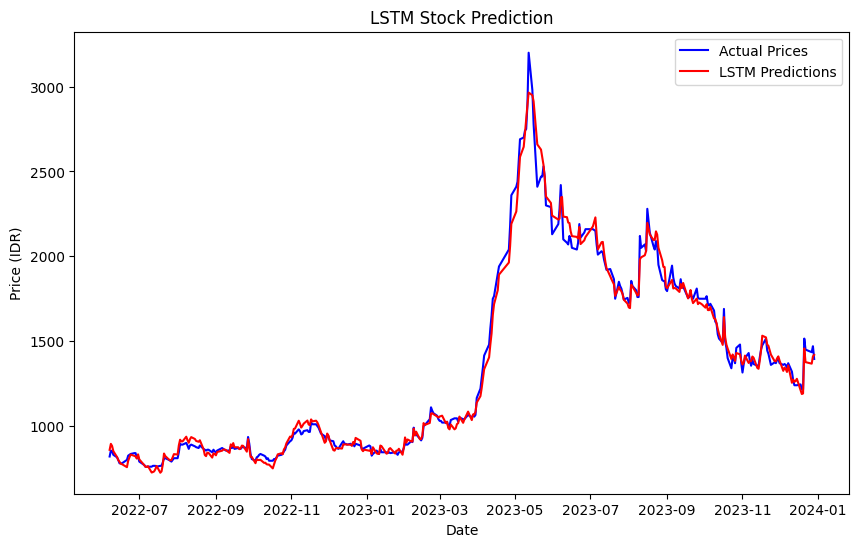

In [ ]:
# Evaluate model
metrics = evaluate_model(y_test, predictions, scaler_target)
print(f"Metrics: RMSE={metrics['RMSE']:.2f}, MAE={metrics['MAE']:.2f}, MAPE={metrics['MAPE']:.2f}%, R2={metrics['R2']:.2f}")

# Plot predictions
plot_predictions(y_test, predictions, stock_data.index[-len(y_test):], scaler_target)


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=stock_data.index[-len(y_test):], 
                         y=scaler_target.inverse_transform(y_test).flatten(), 
                         mode='lines', name='Actual Prices', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=stock_data.index[-len(predictions):], 
                         y=predictions_rescaled.flatten(), 
                         mode='lines', name='LSTM Predictions', line=dict(color='red')))
fig.update_layout(title='LSTM Stock Prediction', xaxis_title='Date', yaxis_title='Price (IDR)')
fig.show()


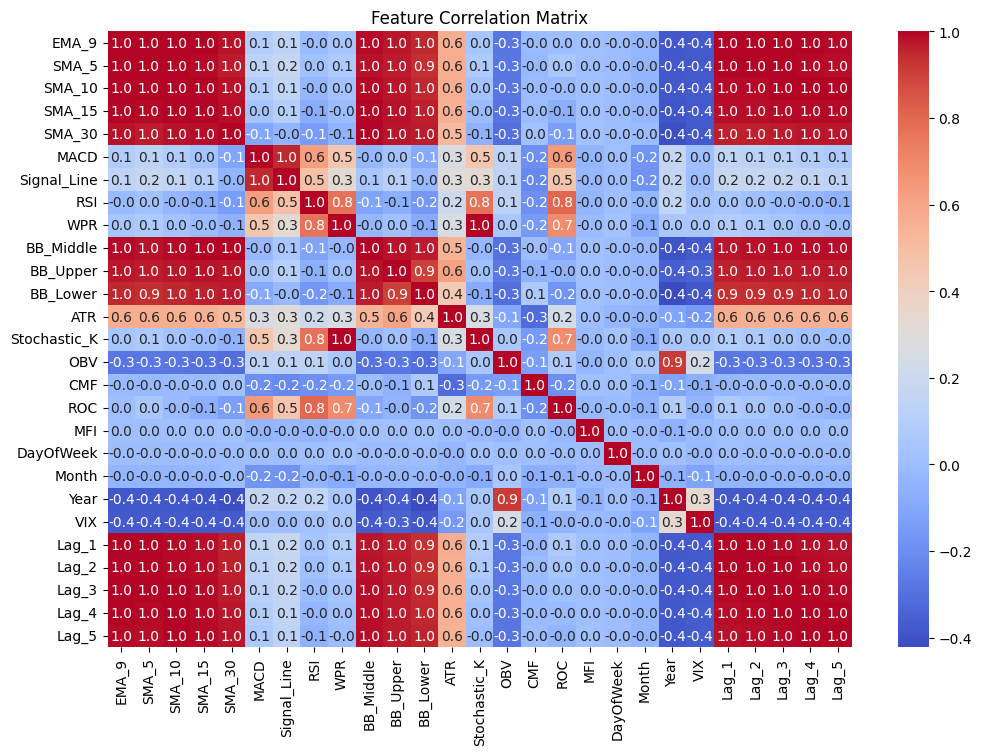

In [ ]:
import seaborn as sns

# Correlation matrix
corr_matrix = X.corr()

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.1f', cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()


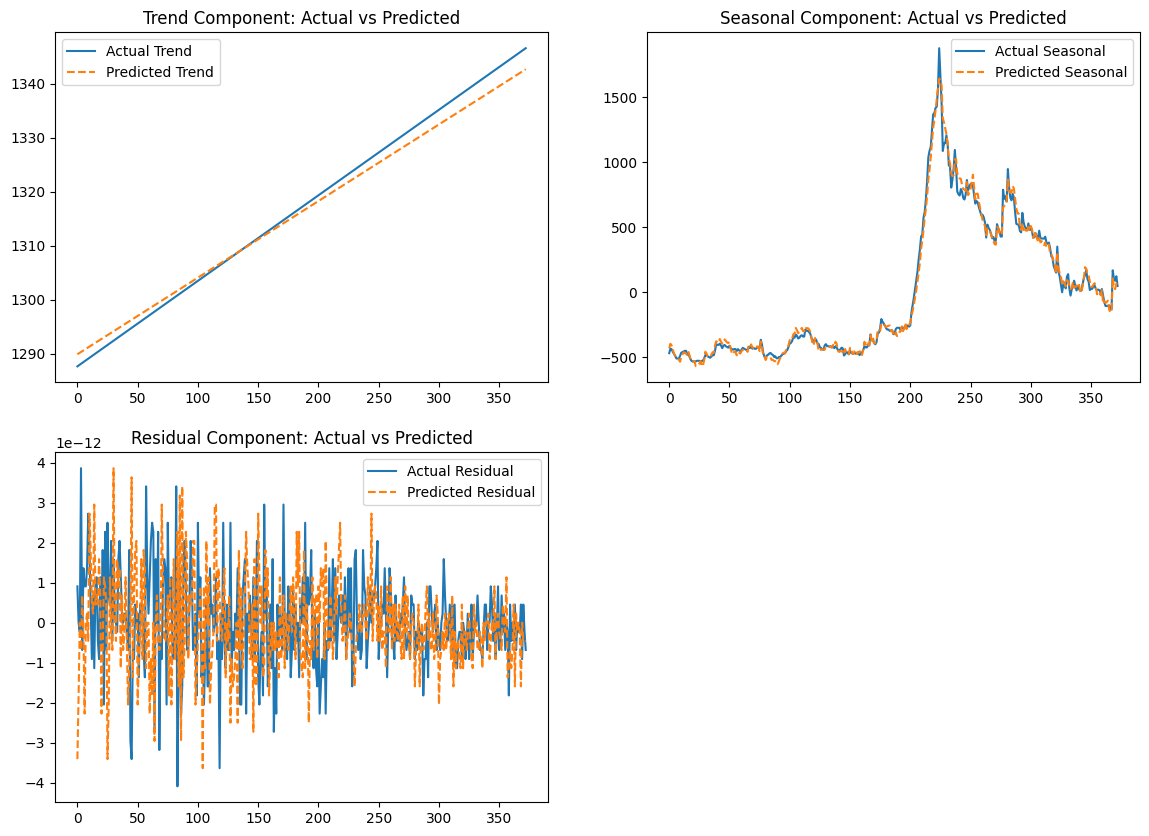

In [ ]:
# STL decomposition for trend, seasonal, and residual components
def stl_decompose(data):
    stl = STL(data, period=365)
    result = stl.fit()
    return result.trend, result.seasonal, result.resid

# Decompose actual and predicted data
actual_trend, actual_seasonal, actual_residual = stl_decompose(y_test_rescaled)
pred_trend, pred_seasonal, pred_residual = stl_decompose(predictions_rescaled)

# Plotting
plt.figure(figsize=(14, 10))

# Actual vs Predicted Trend
plt.subplot(2, 2, 1)
plt.plot(actual_trend, label='Actual Trend')
plt.plot(pred_trend, label='Predicted Trend', linestyle='--')
plt.title('Trend Component: Actual vs Predicted')
plt.legend()

# Actual vs Predicted Seasonal
plt.subplot(2, 2, 2)
plt.plot(actual_seasonal, label='Actual Seasonal')
plt.plot(pred_seasonal, label='Predicted Seasonal', linestyle='--')
plt.title('Seasonal Component: Actual vs Predicted')
plt.legend()

# Actual vs Predicted Residual
plt.subplot(2, 2, 3)
plt.plot(actual_residual, label='Actual Residual')
plt.plot(pred_residual, label='Predicted Residual', linestyle='--')
plt.title('Residual Component: Actual vs Predicted')
plt.legend()


In [ ]:
import shap
import numpy as np
import tensorflow as tf

# Define a wrapper for the LSTM model's predict method to return a NumPy array
def model_predict(X):
    # Ensure that the input is in the correct format (batch_size, timesteps, features)
    X = np.array(X)  # Convert to NumPy array if not already
    if len(X.shape) == 2:  # If data is only (samples, features), we add a dummy time axis
        X = X.reshape(X.shape[0], 1, X.shape[1])  # Add dummy time axis
    elif len(X.shape) == 3:  # If data has (samples, timesteps, features)
        pass  # No reshaping needed
    
    # Use the model to predict, return as NumPy array (no need for .numpy() here)
    return best_model.predict(X, verbose=0)

# Create SHAP explainer with the wrapper function
# We reshape X_train to (samples, features) if it has 3 dimensions to be compatible with the explainer
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[2])

# Use the reshaped data as background data for SHAP
explainer = shap.KernelExplainer(model_predict, X_train_reshaped)

# Calculate SHAP values for the reshaped test set
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[2])  # Ensure correct shape for test set
shap_values = explainer.shap_values(X_test_reshaped)

# Now proceed with your SHAP value processing and visualization
shap_values_mean = np.abs(shap_values).mean(axis=1).mean(axis=0)
shap_df = pd.DataFrame({'Feature': feature_columns, 'Mean SHAP Value': shap_values_mean}).sort_values(by='Mean SHAP Value', ascending=False)

# Plot SHAP feature importance using Plotly
import plotly.express as px

fig = px.bar(shap_df, x='Mean SHAP Value', y='Feature', orientation='h', title='LSTM Feature Importance')
fig.update_layout(yaxis=dict(title='Feature'), xaxis=dict(title='Mean SHAP Value'), height=600)
fig.show()
